In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'random_occlusion', 'blur'}
Validation folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'random_occlusion', 'blur'}
Test folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'random_occlusion', 'blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'blur'}
Validation folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'blur'}
Test folders considered: {'low_resolution', 'motion_blur', 'dirty_lens', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'original', 'blur'}


In [7]:

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Module):
    """Standard convolution block: Conv2d + BatchNorm + ReLU6"""
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = norm_layer(out_planes)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu6(x, inplace=True)

class InvertedResidual(nn.Module):
    """Inverted Residual Block (Mobile Inverted Bottleneck)"""
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup
        
        layers = []
        
        if expand_ratio != 1:
            # Pointwise expansion (1x1 conv)
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        
        layers.extend([
            # Depthwise convolution (3x3 conv with groups)
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # Pointwise projection (1x1 conv without ReLU)
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MyMobileNetV2(nn.Module):
    """MobileNetV2 Implementation from Scratch"""
    def __init__(self, num_classes=4, width_mult=1.0, inverted_residual_setting=None, 
                 round_nearest=8, block=None, norm_layer=None):
        super().__init__()
        
        if block is None:
            block = InvertedResidual
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        input_channel = 32
        last_channel = 1280
        
        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],   # Stage 1
                [6, 24, 2, 2],   # Stage 2
                [6, 32, 3, 2],   # Stage 3
                [6, 64, 4, 2],   # Stage 4
                [6, 96, 3, 1],   # Stage 5
                [6, 160, 3, 2],  # Stage 6
                [6, 320, 1, 1],  # Stage 7
            ]
        
        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                           "or a 4-element list, got {}".format(inverted_residual_setting))
        
        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        
        # make it nn.Sequential
        self.features = nn.Sequential(*features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )
        
        # weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)




In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyMobileNetV2(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("MobileNetV2 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")



MobileNetV2 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
        ConvBNReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
        ConvBNReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
       ConvBNReLU-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchN


🚀 Starting MobileNetV2 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:29<00:00,  1.63it/s, Loss=0.6871, Acc=0.6033]


✅ Training completed in 29.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:05<00:00,  2.12it/s, Loss=0.7343, Acc=0.3750]


✅ Validation completed in 5.68s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.3750

📊 Epoch 1 Summary:
│ Train Loss: 0.6871 | Train Acc: 0.6033
│ Val Loss:   0.7343 | Val Acc:   0.3750
│ Train Time: 29.46s | Val Time: 5.68s
│ Total Epoch Time: 35.14s
│ Best Val Acc: 0.3750 (Epoch 1)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.64it/s, Loss=0.6042, Acc=0.6855]


✅ Training completed in 18.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.40it/s, Loss=0.7698, Acc=0.6458]


✅ Validation completed in 2.73s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6458

📊 Epoch 2 Summary:
│ Train Loss: 0.6042 | Train Acc: 0.6855
│ Val Loss:   0.7698 | Val Acc:   0.6458
│ Train Time: 18.20s | Val Time: 2.73s
│ Total Epoch Time: 20.93s
│ Best Val Acc: 0.6458 (Epoch 2)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.66it/s, Loss=0.4961, Acc=0.7724]


✅ Training completed in 18.07s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.23it/s, Loss=0.9750, Acc=0.6198]


✅ Validation completed in 2.84s

📊 Epoch 3 Summary:
│ Train Loss: 0.4961 | Train Acc: 0.7724
│ Val Loss:   0.9750 | Val Acc:   0.6198
│ Train Time: 18.07s | Val Time: 2.84s
│ Total Epoch Time: 20.91s
│ Best Val Acc: 0.6458 (Epoch 2)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.65it/s, Loss=0.3605, Acc=0.8408]


✅ Training completed in 18.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.21it/s, Loss=0.8075, Acc=0.6432]


✅ Validation completed in 2.86s

📊 Epoch 4 Summary:
│ Train Loss: 0.3605 | Train Acc: 0.8408
│ Val Loss:   0.8075 | Val Acc:   0.6432
│ Train Time: 18.13s | Val Time: 2.86s
│ Total Epoch Time: 20.99s
│ Best Val Acc: 0.6458 (Epoch 2)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.68it/s, Loss=0.2255, Acc=0.9132]


✅ Training completed in 17.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.25it/s, Loss=0.9469, Acc=0.6589]


✅ Validation completed in 2.82s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6589

📊 Epoch 5 Summary:
│ Train Loss: 0.2255 | Train Acc: 0.9132
│ Val Loss:   0.9469 | Val Acc:   0.6589
│ Train Time: 17.91s | Val Time: 2.82s
│ Total Epoch Time: 20.74s
│ Best Val Acc: 0.6589 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.79it/s, Loss=0.2133, Acc=0.9151]


✅ Training completed in 17.23s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.51it/s, Loss=0.9857, Acc=0.6510]


✅ Validation completed in 2.66s

📊 Epoch 6 Summary:
│ Train Loss: 0.2133 | Train Acc: 0.9151
│ Val Loss:   0.9857 | Val Acc:   0.6510
│ Train Time: 17.23s | Val Time: 2.66s
│ Total Epoch Time: 19.90s
│ Best Val Acc: 0.6589 (Epoch 5)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.74it/s, Loss=0.1443, Acc=0.9500]


✅ Training completed in 17.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.30it/s, Loss=0.9308, Acc=0.6667]


✅ Validation completed in 2.79s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.6667

📊 Epoch 7 Summary:
│ Train Loss: 0.1443 | Train Acc: 0.9500
│ Val Loss:   0.9308 | Val Acc:   0.6667
│ Train Time: 17.53s | Val Time: 2.79s
│ Total Epoch Time: 20.33s
│ Best Val Acc: 0.6667 (Epoch 7)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.73it/s, Loss=0.0968, Acc=0.9592]


✅ Training completed in 17.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.56it/s, Loss=1.0171, Acc=0.7135]


✅ Validation completed in 2.63s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.7135

📊 Epoch 8 Summary:
│ Train Loss: 0.0968 | Train Acc: 0.9592
│ Val Loss:   1.0171 | Val Acc:   0.7135
│ Train Time: 17.60s | Val Time: 2.63s
│ Total Epoch Time: 20.25s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.66it/s, Loss=0.0975, Acc=0.9678]


✅ Training completed in 18.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.57it/s, Loss=1.2384, Acc=0.6641]


✅ Validation completed in 2.63s

📊 Epoch 9 Summary:
│ Train Loss: 0.0975 | Train Acc: 0.9678
│ Val Loss:   1.2384 | Val Acc:   0.6641
│ Train Time: 18.03s | Val Time: 2.63s
│ Total Epoch Time: 20.66s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.78it/s, Loss=0.0969, Acc=0.9638]


✅ Training completed in 17.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.67it/s, Loss=1.5551, Acc=0.6719]


✅ Validation completed in 2.57s

📊 Epoch 10 Summary:
│ Train Loss: 0.0969 | Train Acc: 0.9638
│ Val Loss:   1.5551 | Val Acc:   0.6719
│ Train Time: 17.26s | Val Time: 2.57s
│ Total Epoch Time: 19.83s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.84it/s, Loss=0.0635, Acc=0.9770]


✅ Training completed in 16.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.97it/s, Loss=1.4689, Acc=0.6146]


✅ Validation completed in 2.42s

📊 Epoch 11 Summary:
│ Train Loss: 0.0635 | Train Acc: 0.9770
│ Val Loss:   1.4689 | Val Acc:   0.6146
│ Train Time: 16.89s | Val Time: 2.42s
│ Total Epoch Time: 19.31s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.83it/s, Loss=0.0709, Acc=0.9724]


✅ Training completed in 16.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.84it/s, Loss=1.4778, Acc=0.6094]


✅ Validation completed in 2.48s

📊 Epoch 12 Summary:
│ Train Loss: 0.0709 | Train Acc: 0.9724
│ Val Loss:   1.4778 | Val Acc:   0.6094
│ Train Time: 16.95s | Val Time: 2.48s
│ Total Epoch Time: 19.44s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.71it/s, Loss=0.0728, Acc=0.9730]


✅ Training completed in 17.75s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.20it/s, Loss=1.2335, Acc=0.6901]


✅ Validation completed in 2.86s

📊 Epoch 13 Summary:
│ Train Loss: 0.0728 | Train Acc: 0.9730
│ Val Loss:   1.2335 | Val Acc:   0.6901
│ Train Time: 17.75s | Val Time: 2.86s
│ Total Epoch Time: 20.61s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.79it/s, Loss=0.0704, Acc=0.9717]


✅ Training completed in 17.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.86it/s, Loss=1.6315, Acc=0.6432]


✅ Validation completed in 2.47s

📊 Epoch 14 Summary:
│ Train Loss: 0.0704 | Train Acc: 0.9717
│ Val Loss:   1.6315 | Val Acc:   0.6432
│ Train Time: 17.19s | Val Time: 2.47s
│ Total Epoch Time: 19.67s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.59it/s, Loss=0.0595, Acc=0.9796]


✅ Training completed in 18.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.36it/s, Loss=1.4014, Acc=0.7135]


✅ Validation completed in 2.76s

📊 Epoch 15 Summary:
│ Train Loss: 0.0595 | Train Acc: 0.9796
│ Val Loss:   1.4014 | Val Acc:   0.7135
│ Train Time: 18.56s | Val Time: 2.76s
│ Total Epoch Time: 21.32s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.63it/s, Loss=0.0510, Acc=0.9822]


✅ Training completed in 18.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.80it/s, Loss=1.3739, Acc=0.6536]


✅ Validation completed in 2.50s

📊 Epoch 16 Summary:
│ Train Loss: 0.0510 | Train Acc: 0.9822
│ Val Loss:   1.3739 | Val Acc:   0.6536
│ Train Time: 18.26s | Val Time: 2.50s
│ Total Epoch Time: 20.76s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.67it/s, Loss=0.0389, Acc=0.9836]


✅ Training completed in 17.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.26it/s, Loss=1.7925, Acc=0.6354]


✅ Validation completed in 2.82s

📊 Epoch 17 Summary:
│ Train Loss: 0.0389 | Train Acc: 0.9836
│ Val Loss:   1.7925 | Val Acc:   0.6354
│ Train Time: 17.98s | Val Time: 2.82s
│ Total Epoch Time: 20.81s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.74it/s, Loss=0.0436, Acc=0.9849]


✅ Training completed in 17.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.29it/s, Loss=1.4489, Acc=0.6849]


✅ Validation completed in 2.80s

📊 Epoch 18 Summary:
│ Train Loss: 0.0436 | Train Acc: 0.9849
│ Val Loss:   1.4489 | Val Acc:   0.6849
│ Train Time: 17.54s | Val Time: 2.80s
│ Total Epoch Time: 20.35s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.80it/s, Loss=0.0295, Acc=0.9895]


✅ Training completed in 17.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.47it/s, Loss=1.3937, Acc=0.6823]


✅ Validation completed in 2.69s

📊 Epoch 19 Summary:
│ Train Loss: 0.0295 | Train Acc: 0.9895
│ Val Loss:   1.3937 | Val Acc:   0.6823
│ Train Time: 17.15s | Val Time: 2.69s
│ Total Epoch Time: 19.84s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.68it/s, Loss=0.0335, Acc=0.9875]


✅ Training completed in 17.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.80it/s, Loss=1.1992, Acc=0.6875]


✅ Validation completed in 2.51s

📊 Epoch 20 Summary:
│ Train Loss: 0.0335 | Train Acc: 0.9875
│ Val Loss:   1.1992 | Val Acc:   0.6875
│ Train Time: 17.94s | Val Time: 2.51s
│ Total Epoch Time: 20.45s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.73it/s, Loss=0.0475, Acc=0.9789]


✅ Training completed in 17.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.60it/s, Loss=1.7048, Acc=0.6901]


✅ Validation completed in 2.61s

📊 Epoch 21 Summary:
│ Train Loss: 0.0475 | Train Acc: 0.9789
│ Val Loss:   1.7048 | Val Acc:   0.6901
│ Train Time: 17.58s | Val Time: 2.61s
│ Total Epoch Time: 20.19s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.81it/s, Loss=0.0275, Acc=0.9908]


✅ Training completed in 17.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.82it/s, Loss=1.4567, Acc=0.6641]


✅ Validation completed in 2.49s

📊 Epoch 22 Summary:
│ Train Loss: 0.0275 | Train Acc: 0.9908
│ Val Loss:   1.4567 | Val Acc:   0.6641
│ Train Time: 17.09s | Val Time: 2.49s
│ Total Epoch Time: 19.59s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.69it/s, Loss=0.0193, Acc=0.9941]


✅ Training completed in 17.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.47it/s, Loss=1.5567, Acc=0.6667]


✅ Validation completed in 2.69s

📊 Epoch 23 Summary:
│ Train Loss: 0.0193 | Train Acc: 0.9941
│ Val Loss:   1.5567 | Val Acc:   0.6667
│ Train Time: 17.84s | Val Time: 2.69s
│ Total Epoch Time: 20.53s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.79it/s, Loss=0.0352, Acc=0.9888]


✅ Training completed in 17.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.94it/s, Loss=1.7751, Acc=0.6875]


✅ Validation completed in 2.43s

📊 Epoch 24 Summary:
│ Train Loss: 0.0352 | Train Acc: 0.9888
│ Val Loss:   1.7751 | Val Acc:   0.6875
│ Train Time: 17.22s | Val Time: 2.43s
│ Total Epoch Time: 19.66s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.64it/s, Loss=0.0353, Acc=0.9882]


✅ Training completed in 18.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.62it/s, Loss=1.5188, Acc=0.6693]


✅ Validation completed in 2.60s

📊 Epoch 25 Summary:
│ Train Loss: 0.0353 | Train Acc: 0.9882
│ Val Loss:   1.5188 | Val Acc:   0.6693
│ Train Time: 18.20s | Val Time: 2.60s
│ Total Epoch Time: 20.81s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.83it/s, Loss=0.0209, Acc=0.9934]


✅ Training completed in 16.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.99it/s, Loss=1.5622, Acc=0.6510]


✅ Validation completed in 2.41s

📊 Epoch 26 Summary:
│ Train Loss: 0.0209 | Train Acc: 0.9934
│ Val Loss:   1.5622 | Val Acc:   0.6510
│ Train Time: 16.98s | Val Time: 2.41s
│ Total Epoch Time: 19.40s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.61it/s, Loss=0.0195, Acc=0.9928]


✅ Training completed in 18.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.78it/s, Loss=1.7220, Acc=0.6406]


✅ Validation completed in 2.51s

📊 Epoch 27 Summary:
│ Train Loss: 0.0195 | Train Acc: 0.9928
│ Val Loss:   1.7220 | Val Acc:   0.6406
│ Train Time: 18.41s | Val Time: 2.51s
│ Total Epoch Time: 20.92s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:17<00:00,  2.82it/s, Loss=0.0289, Acc=0.9882]


✅ Training completed in 17.04s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.81it/s, Loss=2.0108, Acc=0.6823]


✅ Validation completed in 2.50s

📊 Epoch 28 Summary:
│ Train Loss: 0.0289 | Train Acc: 0.9882
│ Val Loss:   2.0108 | Val Acc:   0.6823
│ Train Time: 17.04s | Val Time: 2.50s
│ Total Epoch Time: 19.54s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:18<00:00,  2.65it/s, Loss=0.0264, Acc=0.9921]


✅ Training completed in 18.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.87it/s, Loss=1.7482, Acc=0.6693]


✅ Validation completed in 2.47s

📊 Epoch 29 Summary:
│ Train Loss: 0.0264 | Train Acc: 0.9921
│ Val Loss:   1.7482 | Val Acc:   0.6693
│ Train Time: 18.11s | Val Time: 2.47s
│ Total Epoch Time: 20.58s
│ Best Val Acc: 0.7135 (Epoch 8)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.87it/s, Loss=0.0362, Acc=0.9875]


✅ Training completed in 16.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.17it/s, Loss=1.3011, Acc=0.7370]


✅ Validation completed in 2.32s
🌟 New best MobileNetV2 model found! Validation Accuracy: 0.7370

📊 Epoch 30 Summary:
│ Train Loss: 0.0362 | Train Acc: 0.9875
│ Val Loss:   1.3011 | Val Acc:   0.7370
│ Train Time: 16.72s | Val Time: 2.32s
│ Total Epoch Time: 19.05s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0201, Acc=0.9947]


✅ Training completed in 16.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.02it/s, Loss=1.3780, Acc=0.6979]


✅ Validation completed in 2.39s

📊 Epoch 31 Summary:
│ Train Loss: 0.0201 | Train Acc: 0.9947
│ Val Loss:   1.3780 | Val Acc:   0.6979
│ Train Time: 16.46s | Val Time: 2.39s
│ Total Epoch Time: 18.85s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0177, Acc=0.9921]


✅ Training completed in 16.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.14it/s, Loss=1.2351, Acc=0.7292]


✅ Validation completed in 2.34s

📊 Epoch 32 Summary:
│ Train Loss: 0.0177 | Train Acc: 0.9921
│ Val Loss:   1.2351 | Val Acc:   0.7292
│ Train Time: 16.39s | Val Time: 2.34s
│ Total Epoch Time: 18.73s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0146, Acc=0.9954]


✅ Training completed in 16.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.65it/s, Loss=1.3507, Acc=0.6927]


✅ Validation completed in 2.58s

📊 Epoch 33 Summary:
│ Train Loss: 0.0146 | Train Acc: 0.9954
│ Val Loss:   1.3507 | Val Acc:   0.6927
│ Train Time: 16.32s | Val Time: 2.58s
│ Total Epoch Time: 18.91s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0049, Acc=0.9987]


✅ Training completed in 16.42s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.06it/s, Loss=1.4387, Acc=0.7031]


✅ Validation completed in 2.38s

📊 Epoch 34 Summary:
│ Train Loss: 0.0049 | Train Acc: 0.9987
│ Val Loss:   1.4387 | Val Acc:   0.7031
│ Train Time: 16.42s | Val Time: 2.38s
│ Total Epoch Time: 18.80s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0082, Acc=0.9980]


✅ Training completed in 16.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.16it/s, Loss=1.8286, Acc=0.6641]


✅ Validation completed in 2.33s

📊 Epoch 35 Summary:
│ Train Loss: 0.0082 | Train Acc: 0.9980
│ Val Loss:   1.8286 | Val Acc:   0.6641
│ Train Time: 16.21s | Val Time: 2.33s
│ Total Epoch Time: 18.54s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0198, Acc=0.9941]


✅ Training completed in 16.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.02it/s, Loss=1.4922, Acc=0.6745]


✅ Validation completed in 2.39s

📊 Epoch 36 Summary:
│ Train Loss: 0.0198 | Train Acc: 0.9941
│ Val Loss:   1.4922 | Val Acc:   0.6745
│ Train Time: 16.39s | Val Time: 2.39s
│ Total Epoch Time: 18.78s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0058, Acc=0.9987]


✅ Training completed in 16.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.09it/s, Loss=1.6771, Acc=0.6849]


✅ Validation completed in 2.36s

📊 Epoch 37 Summary:
│ Train Loss: 0.0058 | Train Acc: 0.9987
│ Val Loss:   1.6771 | Val Acc:   0.6849
│ Train Time: 16.45s | Val Time: 2.36s
│ Total Epoch Time: 18.81s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0068, Acc=0.9980]


✅ Training completed in 16.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.15it/s, Loss=1.6525, Acc=0.6536]


✅ Validation completed in 2.33s

📊 Epoch 38 Summary:
│ Train Loss: 0.0068 | Train Acc: 0.9980
│ Val Loss:   1.6525 | Val Acc:   0.6536
│ Train Time: 16.26s | Val Time: 2.33s
│ Total Epoch Time: 18.60s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.89it/s, Loss=0.0076, Acc=0.9967]


✅ Training completed in 16.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.00it/s, Loss=1.4713, Acc=0.6693]


✅ Validation completed in 2.40s

📊 Epoch 39 Summary:
│ Train Loss: 0.0076 | Train Acc: 0.9967
│ Val Loss:   1.4713 | Val Acc:   0.6693
│ Train Time: 16.63s | Val Time: 2.40s
│ Total Epoch Time: 19.03s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0030, Acc=0.9987]


✅ Training completed in 16.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.97it/s, Loss=1.6437, Acc=0.6667]


✅ Validation completed in 2.42s

📊 Epoch 40 Summary:
│ Train Loss: 0.0030 | Train Acc: 0.9987
│ Val Loss:   1.6437 | Val Acc:   0.6667
│ Train Time: 16.47s | Val Time: 2.42s
│ Total Epoch Time: 18.89s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.89it/s, Loss=0.0013, Acc=1.0000]


✅ Training completed in 16.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.25it/s, Loss=1.5884, Acc=0.6771]


✅ Validation completed in 2.29s

📊 Epoch 41 Summary:
│ Train Loss: 0.0013 | Train Acc: 1.0000
│ Val Loss:   1.5884 | Val Acc:   0.6771
│ Train Time: 16.61s | Val Time: 2.29s
│ Total Epoch Time: 18.90s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0024, Acc=0.9993]


✅ Training completed in 16.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.04it/s, Loss=1.8553, Acc=0.6354]


✅ Validation completed in 2.38s

📊 Epoch 42 Summary:
│ Train Loss: 0.0024 | Train Acc: 0.9993
│ Val Loss:   1.8553 | Val Acc:   0.6354
│ Train Time: 16.26s | Val Time: 2.38s
│ Total Epoch Time: 18.65s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0051, Acc=0.9987]


✅ Training completed in 16.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.98it/s, Loss=1.7371, Acc=0.6615]


✅ Validation completed in 2.41s

📊 Epoch 43 Summary:
│ Train Loss: 0.0051 | Train Acc: 0.9987
│ Val Loss:   1.7371 | Val Acc:   0.6615
│ Train Time: 16.38s | Val Time: 2.41s
│ Total Epoch Time: 18.80s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0228, Acc=0.9914]


✅ Training completed in 16.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.18it/s, Loss=2.0511, Acc=0.6927]


✅ Validation completed in 2.32s

📊 Epoch 44 Summary:
│ Train Loss: 0.0228 | Train Acc: 0.9914
│ Val Loss:   2.0511 | Val Acc:   0.6927
│ Train Time: 16.45s | Val Time: 2.32s
│ Total Epoch Time: 18.77s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.99it/s, Loss=0.1078, Acc=0.9638]


✅ Training completed in 16.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.03it/s, Loss=1.8665, Acc=0.6042]


✅ Validation completed in 2.39s

📊 Epoch 45 Summary:
│ Train Loss: 0.1078 | Train Acc: 0.9638
│ Val Loss:   1.8665 | Val Acc:   0.6042
│ Train Time: 16.05s | Val Time: 2.39s
│ Total Epoch Time: 18.44s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0500, Acc=0.9829]


✅ Training completed in 16.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.06it/s, Loss=1.8426, Acc=0.6172]


✅ Validation completed in 2.38s

📊 Epoch 46 Summary:
│ Train Loss: 0.0500 | Train Acc: 0.9829
│ Val Loss:   1.8426 | Val Acc:   0.6172
│ Train Time: 16.29s | Val Time: 2.38s
│ Total Epoch Time: 18.67s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.90it/s, Loss=0.0395, Acc=0.9849]


✅ Training completed in 16.56s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.17it/s, Loss=1.9299, Acc=0.6484]


✅ Validation completed in 2.32s

📊 Epoch 47 Summary:
│ Train Loss: 0.0395 | Train Acc: 0.9849
│ Val Loss:   1.9299 | Val Acc:   0.6484
│ Train Time: 16.56s | Val Time: 2.32s
│ Total Epoch Time: 18.89s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0355, Acc=0.9875]


✅ Training completed in 16.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.18it/s, Loss=1.8053, Acc=0.6458]


✅ Validation completed in 2.32s

📊 Epoch 48 Summary:
│ Train Loss: 0.0355 | Train Acc: 0.9875
│ Val Loss:   1.8053 | Val Acc:   0.6458
│ Train Time: 16.20s | Val Time: 2.32s
│ Total Epoch Time: 18.52s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0339, Acc=0.9921]


✅ Training completed in 16.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.11it/s, Loss=1.5823, Acc=0.6328]


✅ Validation completed in 2.35s

📊 Epoch 49 Summary:
│ Train Loss: 0.0339 | Train Acc: 0.9921
│ Val Loss:   1.5823 | Val Acc:   0.6328
│ Train Time: 16.24s | Val Time: 2.35s
│ Total Epoch Time: 18.60s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0169, Acc=0.9941]


✅ Training completed in 16.26s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.13it/s, Loss=2.2049, Acc=0.6224]


✅ Validation completed in 2.34s

📊 Epoch 50 Summary:
│ Train Loss: 0.0169 | Train Acc: 0.9941
│ Val Loss:   2.2049 | Val Acc:   0.6224
│ Train Time: 16.26s | Val Time: 2.34s
│ Total Epoch Time: 18.60s
│ Best Val Acc: 0.7370 (Epoch 30)
│ GPU Memory: 0.1GB / 2.8GB

💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'
📊 Best model stats:
│ Best Epoch: 30
│ Best Val Acc: 0.7370

💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'

🎉 MobileNetV2 Training Complete!
Total Training Time: 997.33s (16.6 minutes)
Average Epoch Time: 19.95s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 35.14s
│ Epoch 2: 20.93s
│ Epoch 3: 20.91s
│ Epoch 4: 20.99s
│ Epoch 5: 20.74s
│ Epoch 6: 19.90s
│ Epoch 7: 20.33s
│ Epoch 8: 20.25s
│ Epoch 9: 20.66s
│ Epoch 10: 19.83s
│ Epoch 11: 19.31s
│ Epoch 12: 19.44s
│ Epoch 13: 20.61s
│ Epoch 14: 19.67s
│ Epoch 15: 21.32s
│ Epoch 16: 20.76s
│ Epoch 17: 20.81s
│ Epoch 18: 20.35s
│ Epoch 19: 19.84s
│ Epoch 20: 20.45s
│ Epoch 21: 20.19s
│ Epoch 22: 1

Testing MobileNetV2: 100%|██████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


✅ MobileNetV2 Testing completed in 6.97s

📋 MobileNetV2 Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.72      0.71      0.72       304
   spin_bowl       0.53      0.55      0.54       184

    accuracy                           0.65       488
   macro avg       0.63      0.63      0.63       488
weighted avg       0.65      0.65      0.65       488

🎯 MobileNetV2 Test Accuracy: 0.6496

📊 MobileNetV2 Model Performance Summary:
│ Best Validation Acc:  0.7370 (Epoch 30)
│ Final Test Accuracy:  0.6496
│ Val-Test Gap:         0.0874


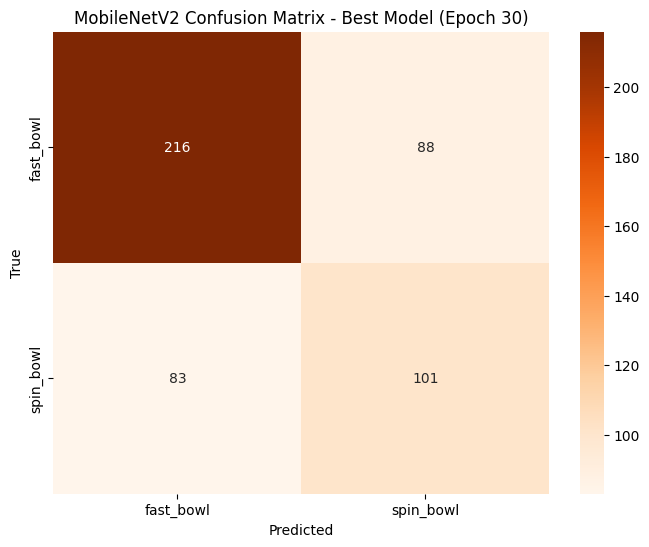

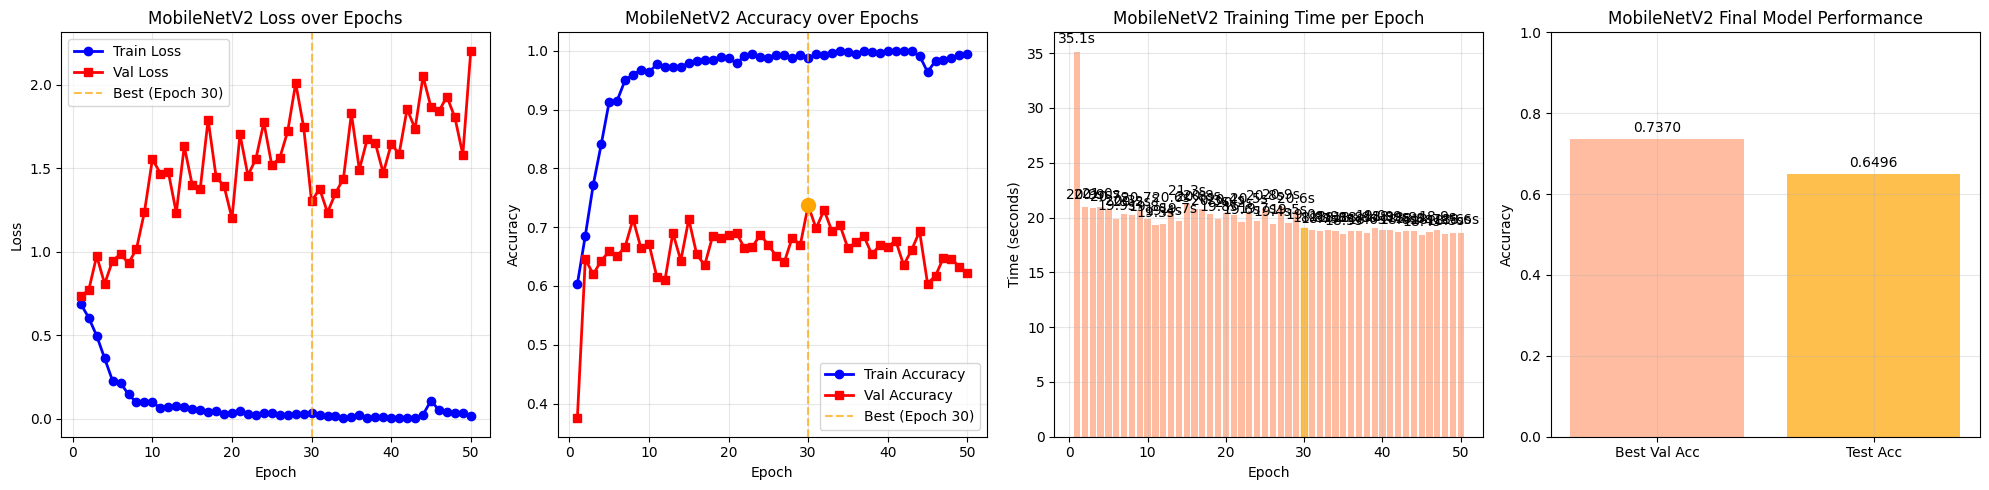


⏰ MobileNetV2 Final Timing Summary:
│ Total Training: 997.33s
│ Average per Epoch: 19.95s
│ Testing Time: 6.97s
│ Total Runtime: 1004.30s

💾 MobileNetV2 Files saved:
│ best_mobilenetv2_model.pth - Best validation accuracy model
│ mobilenetv2_training_history.csv - Training metrics for later plotting

🏗️  MobileNetV2 Architecture Summary:
│ Total Parameters: 2,226,434
│ Trainable Parameters: 2,226,434
│ Model Size: 8.49 MB
│ Input Size: 224x224x3
│ Output Classes: 2
│ Width Multiplier: 1.0
│ Inverted Residual Blocks: 17
│ Depthwise Separable Convs: Yes
│ ReLU6 Activation: Yes


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - MobileNetV2
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting MobileNetV2 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best MobileNetV2 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_mobilenetv2_model.pth')
    print(f"\n💾 Best MobileNetV2 model saved as 'best_mobilenetv2_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('mobilenetv2_training_history.csv', index=False)
print("\n💾 MobileNetV2 training history saved to 'mobilenetv2_training_history.csv'")

# Training Summary
print(f"\n🎉 MobileNetV2 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best MobileNetV2 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best MobileNetV2 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing MobileNetV2", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ MobileNetV2 Testing completed in {test_time:.2f}s")
print("\n📋 MobileNetV2 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 MobileNetV2 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 MobileNetV2 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"MobileNetV2 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='orange', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='orange', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightsalmon', alpha=0.7)
bars[best_epoch-1].set_color('orange')
plt.title("MobileNetV2 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightsalmon', 'orange']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ MobileNetV2 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 MobileNetV2 Files saved:")
print(f"│ best_mobilenetv2_model.pth - Best validation accuracy model")
print(f"│ mobilenetv2_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. MobileNetV2 Architecture Summary
# -----------------------------
print(f"\n🏗️  MobileNetV2 Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Width Multiplier: 1.0")
print(f"│ Inverted Residual Blocks: 17")
print(f"│ Depthwise Separable Convs: Yes")
print(f"│ ReLU6 Activation: Yes")